## Computer vision application
## Data preparation

This project aims to explore the computer vision field, from image processing operations to image classification. The data used here is made upon *2527 different images of garbage from 6 different classes*: cardboard, glass, metal, paper, plastic, trash. The ultimate goal is to develop an image classifier model that, after trained and validated using specific datasets, is able to predict the probabilities that a given image belongs to each of those classes. Again, a specific test dataset is applied to evaluate model performance. To achieve that goal, different code artifacts were generated:
* Python modules for image processing and to support model development.
* Notebooks of data engineering and data preparation that apply different operations over images (flip, crop, change in brightness, and so on).
* Notebooks of data modeling that implement experimentation to find the best image classifier model, analysis of the most relevant models and creation of codes to apply the best one in production.

-----------

This notebook reads images and applies different functions and classes developed to implement data augmentation (Keras-based and customized) and image scaling.

**Sumário:**
1. [Libraries](#libraries)<a href='#libraries'></a>.
2. [Functions and classes](#functions_classes)<a href='#functions_classes'></a>.
3. [Settings](#settings)<a href='#settings'></a>.
4. [Importing the data](#data_imports)<a href='#data_imports'></a>.
  * [Data importing and cleaning](#data_imp_clean)<a href='#data_imp_clean'></a>.


5. [Data augmentation](#data_aug)<a href='#data_aug'></a>.
    * [Keras augmentation](#keras_aug)<a href='#keras_aug'></a>.
    * [Custom augmentation](#custom_aug)<a href='#custom_aug'></a>.


6. [Data scaling](#scaling)<a href='#scaling'></a>.
  * [Centering per-channel](#centering)<a href='#centering'></a>.
  * [Normalization](#normalization)<a href='#normalization'></a>.

<a id='libraries'></a>

## Libraries





In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd "/content/gdrive/MyDrive/Studies/computer_vision/notebooks/"

/content/gdrive/MyDrive/Studies/computer_vision/notebooks


In [3]:
# !pip install -r ../requirements.txt

In [4]:
import pandas as pd
import numpy as np
import os
import json
from datetime import datetime
import time
import cv2
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator

In [5]:
import sys

sys.path.append(
    os.path.abspath(
        os.path.join(
            os.path.dirname(__doc__), '../src'
        )
    )
)

<a id='functions_classes'></a>

## Functions and classes

In [6]:
from utils import frequency_list
from data_eng import ImportCleanImages
from data_augmentation import KerasImageAugment, Brightness, Flip, Rotation, Shift, Crop, Blur, ImageAugment
from transformations import ScaleImage

<a id='settings'></a>

## Settings

<a id='files_manag'></a>

### Files management

In [7]:
# Declare whether outcomes should be exported:
export = False

# Declare if images should be imported in grey scale:
grey_scale = False

# Number of sample images:
NUM_IMGS = 50

<a id='image_files'></a>

### Image files

In [8]:
# Available classes:
classes = os.listdir('../data/images/')

# Dictionary with label by class:
label_dict = dict(zip(classes, [i+1 for i in range(len(classes))]))
print(label_dict)

# File names of each dataset:
train_images = [f.split('.')[0] for f in list(pd.read_csv('../data/train_images.txt', sep=' ', header=None)[0])]
val_images = [f.split('.')[0] for f in list(pd.read_csv('../data/val_images.txt', sep=' ', header=None)[0])]
test_images = [f.split('.')[0] for f in list(pd.read_csv('../data/test_images.txt', sep=' ', header=None)[0])]

{'cardboard': 1, 'glass': 2, 'metal': 3, 'paper': 4, 'plastic': 5, 'trash': 6}


<a id='data_imports'></a>

## Importing the data

<a id='data_imp_clean'></a>

### Data importing and cleaning

In [9]:
# Object for collecting and cleaning image data:
import_clean = ImportCleanImages(path_to_files='../data', images_folder='images', train_val_test_file='images', shuffle=True, label_dict=label_dict)
datasets = import_clean.build_datasets()

# Training, validation and test images, labels and ids:
images_train, labels_train, ids_train = datasets['train']
images_val, labels_val, ids_val = datasets['val']
images_test, labels_test, ids_test = datasets['test']

print(f'Shape of images_train: {images_train.shape}.')
print(f'Shape of images_val: {images_val.shape}.')
print(f'Shape of images_test: {images_test.shape}.')

Shape of images_train: (1768, 384, 512, 3).
Shape of images_val: (328, 384, 512, 3).
Shape of images_test: (431, 384, 512, 3).


#### Sanity checks

In [10]:
if len(images_train)!=len(train_images):
  print('Inconsistent number of images between training data and predefined set of training images!')

if len(images_val)!=len(val_images):
  print('Inconsistent number of images between validation data and predefined set of validation images!')

if len(images_test)!=len(test_images):
  print('Inconsistent number of images between test data and predefined set of test images!')

if (len([c for c in ids_train if c not in train_images]) > 0) |\
  (len([c for c in train_images if c not in ids_train]) > 0):
  print('Some images were not found in training data or set of training images!')

if (len([c for c in ids_val if c not in val_images]) > 0) |\
  (len([c for c in val_images if c not in ids_val]) > 0):
  print('Some images were not found in validation data or set of validation images!')

if (len([c for c in ids_test if c not in test_images]) > 0) |\
  (len([c for c in test_images if c not in ids_test]) > 0):
  print('Some images were not found in test data or set of test images!')

<a id='data_aug'></a>

## Data augmentation

In [11]:
# Random sample of images:
random_sample = list(np.random.choice(a=range(len(images_train)), size=NUM_IMGS, replace=False))

sample_imgs = images_train[random_sample, :, :, :]
sample_labels = list(np.array(labels_train)[random_sample])
sample_ids = list(np.array(ids_train)[random_sample])

<a id='keras_aug'></a>

### Keras augmentation

#### Keras API

Text(0.5, 1.0, 'Modified image')

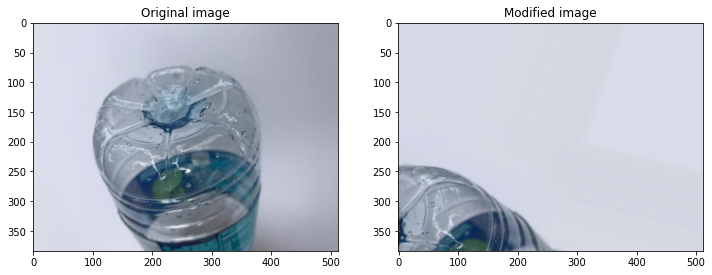

In [12]:
oper_params = {
    'brightness_range': [0.2,1.0],
    'horizontal_flip': True,
    'rotation_range': 90,
    'width_shift_range': [-200,200],
    'height_shift_range': [-200,200],
    'zoom_range': [0.5,1.0],
    'fill_mode': 'nearest'
}
datagen = ImageDataGenerator(**oper_params)

# Creating the iterator:
iter = datagen.flow(x=sample_imgs, shuffle=False, batch_size=len(sample_imgs))

# Applying transformations:
new_batch = iter.next()

# Converting pixels to unsigned integers for viewing:
modified_imgs = []
for i in range(len(new_batch)):
    modified_imgs.append(new_batch[i].astype('uint8'))
modified_imgs = np.array(modified_imgs)

sel_idx = np.random.choice(a=range(len(sample_labels)), size=1, replace=False)[0]

fig, axs = plt.subplots(1, 2, figsize=(12,8))

axs[0].imshow(sample_imgs[25, :, :, :])
axs[0].set_title('Original image')

axs[1].imshow(modified_imgs[25, :, :, :])
axs[1].set_title('Modified image')

#### Wrapper class

In [87]:
# Parameters for Keras data augmentation:
oper_params = {
    'brightness_range': [0.5, 1.5],
    'horizontal_flip': True,
    'vertical_flip': True,
    'rotation_range': 180,
    # 'width_shift_range': [-200,200],
    # 'height_shift_range': [-200,200],
    'zoom_range': [0.5, 1.75],
    'fill_mode': 'nearest'
}

# Object for implementing data augmentation:
data_aug = KerasImageAugment(
    oper_params=oper_params,
    augmentation_factor=2.0
)

# Augmented batch of images:
augmented_imgs, augmented_labels = data_aug.augment_data(images_batch=sample_imgs, labels=sample_labels)

print(f'Shape of augmented_imgs: {augmented_imgs.shape}.')
print(f'Number of augmented labels: {len(augmented_labels)}.')

Shape of augmented_imgs: (100, 384, 512, 3).
Number of augmented labels: 100.


Sample image

Text(0.5, 0.98, 'Image 10: metal236')

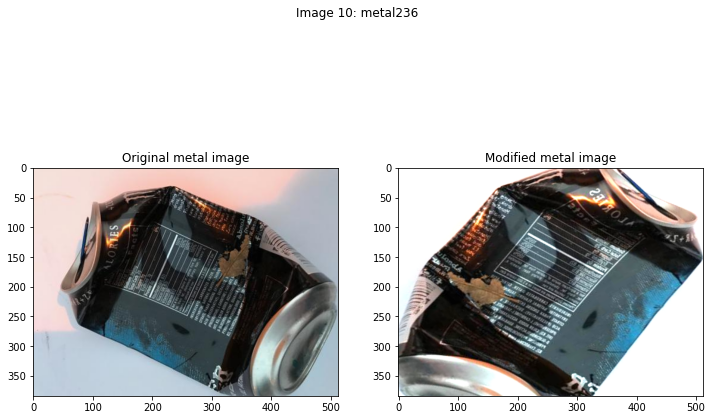

In [88]:
# sel_idx = np.random.choice(a=range(len(sample_labels)), size=1, replace=False)[0]

fig, axs = plt.subplots(1, 2, figsize=(12,8))

axs[0].imshow(augmented_imgs[sel_idx])
axs[0].set_title(f'Original {[k for k, v in label_dict.items() if v==augmented_labels[sel_idx]][0]} image')

axs[1].imshow(augmented_imgs[sel_idx+NUM_IMGS])
axs[1].set_title(f'Modified {[k for k, v in label_dict.items() if v==augmented_labels[sel_idx+NUM_IMGS]][0]} image')

fig.suptitle(f'Image {sel_idx+1}: {sample_ids[sel_idx]}')

All images

In [15]:
for idx in range(len(sample_labels)):
    fig, axs = plt.subplots(1, 2, figsize=(12,8))

    axs[0].imshow(augmented_imgs[idx])
    axs[0].set_title(f'Original {[k for k, v in label_dict.items() if v==augmented_labels[idx]][0]} image')

    axs[1].imshow(augmented_imgs[idx+NUM_IMGS])
    axs[1].set_title(f'Modified {[k for k, v in label_dict.items() if v==augmented_labels[idx+NUM_IMGS]][0]} image')

    fig.suptitle(f'Image {idx+1}: {sample_ids[idx]}')

Output hidden; open in https://colab.research.google.com to view.

<a id='custom_aug'></a>

### Custom augmentation

In [71]:
# Object for implementing data augmentation:
data_aug = ImageAugment(
    operations = (
        Flip(horizontal=True, vertical=True, flip_prob=0.5),
        Rotation(rotation_range=(0, 180), rotation_prob=0.25),
        Blur(kernel_size=(9, 9), blur_prob=0.1),
        Shift(tx_range=(-150, 150), ty_range=(-150, 150), shift_prob=0.2),
        Brightness(change_range=(-0.5, 0.5), bright_prob=0.5),
        Crop(center_range=(0.5, 0.5), window_range=(25, 150), crop_prob=0.25)
    ),
    augmentation_factor = 2.0
)

# Augmented batch of images:
augmented_imgs, augmented_labels = data_aug.augment_data(images_batch=sample_imgs, labels=sample_labels)

print(f'Shape of augmented_imgs: {augmented_imgs.shape}.')
print(f'Number of augmented labels: {len(augmented_labels)}.')

Shape of augmented_imgs: (100, 384, 512, 3).
Number of augmented labels: 100.


Sample image

Text(0.5, 0.98, 'Image 24: paper470')

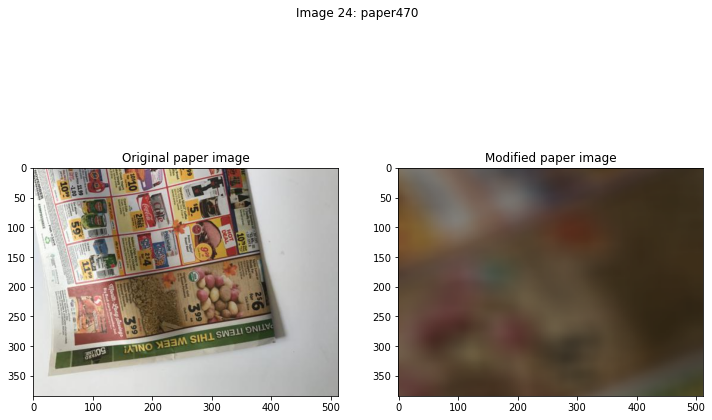

In [ ]:
sel_idx = np.random.choice(a=range(len(sample_labels)), size=1, replace=False)[0]

fig, axs = plt.subplots(1, 2, figsize=(12,8))

axs[0].imshow(augmented_imgs[sel_idx])
axs[0].set_title(f'Original {[k for k, v in label_dict.items() if v==augmented_labels[sel_idx]][0]} image')

axs[1].imshow(augmented_imgs[sel_idx+NUM_IMGS])
axs[1].set_title(f'Modified {[k for k, v in label_dict.items() if v==augmented_labels[sel_idx+NUM_IMGS]][0]} image')

fig.suptitle(f'Image {sel_idx+1}: {sample_ids[sel_idx]}')

All images

In [ ]:
for idx in range(len(sample_labels)):
    fig, axs = plt.subplots(1, 2, figsize=(12,8))

    axs[0].imshow(augmented_imgs[idx])
    axs[0].set_title(f'Original {[k for k, v in label_dict.items() if v==augmented_labels[idx]][0]} image')

    axs[1].imshow(augmented_imgs[idx+NUM_IMGS])
    axs[1].set_title(f'Modified {[k for k, v in label_dict.items() if v==augmented_labels[idx+NUM_IMGS]][0]} image')

    fig.suptitle(f'Image {idx+1}: {sample_ids[idx]}')

Output hidden; open in https://colab.research.google.com to view.

<a id='scaling'></a>

## Data scaling

<a id='centering'></a>

### Centering per-channel

<a id='normalization'></a>

### Normalization

In [ ]:
# Object for scaling data:
scale_imgs = ScaleImage()

# Scaled batch of images:
scaled_imgs = scale_imgs.transform(images_batch=sample_imgs)

print(f'Shape of sample_imgs: {sample_imgs.shape}.')
print(f'Shape of scaled_imgs: {scaled_imgs.shape}.')

Shape of sample_imgs: (50, 384, 512, 3).
Shape of scaled_imgs: (50, 384, 512, 3).
